# Machine Learning Model Building

In [76]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random 
import pickle 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.feature_selection import RFE
from sklearn.datasets import make_regression

import xgboost as xgb
from xgboost import XGBRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from functions.models import plot_predicted_vs_actual, plot_feature_importance

In [78]:
# Import cleaned DataFrame from previous notebook: 3_clean_and_filteripynb

df = pd.read_csv('data/clean/cleaned_parkrun_no_outliers.csv')

## Process DataFrame into format for model

Does the following processing:
- Converts age groups to number
- Converts gender to 1/0 for Male/Female
- Drops null value columns
- Adds Days_since_first_parkrun column
- Removes unnecessary columns

In [ ]:
def process_parkrun_data_for_models(df):
    """
    Preprocess the parkrun data from a CSV file.

    Parameters:
    - df: The cleaned dataframe

    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    # Default age group mapping if none is provided

    age_group_map = {
        '18-19': 19,
        '20-24': 22,
        '25-29': 27,
        '30-34': 32,
        '35-39': 37,
        '40-44': 42,
        '45-49': 47,
        '50-54': 52,
        '55-59': 57,
        '60-64': 62,
        '65-69': 67,
        '70-74': 72
    }
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Map 'Age_group' to numeric values
    df['Age_group_numeric'] = df['Age_group'].map(age_group_map)
    
    # Calculate the first parkrun date for each runner
    df['first_parkrun_date'] = df.groupby('Runner_id')['Date'].transform('min')
    
    # Calculate days since the first parkrun
    df['Days_since_first_parkrun'] = (df['Date'] - df['first_parkrun_date']).dt.days
    
    # Map gender to binary values
    df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
    
    # Drop rows with missing values
    df = df.dropna()
    
    return df

In [82]:
df = process_parkrun_data_for_models(df)
df.columns

Index(['Date', 'Position', 'Position_score', 'Name', 'Runner_id',
       'Parkrun_count', 'Gender', 'Age_group', 'Time_in_minutes',
       'temperature', 'windspeed', 'precipitation', 'Total_Appearances',
       'Appearance_Instance', 'Days_since_last_parkrun', 'Total_event_runners',
       'PB_mins', 'ave_mins', 'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'first_parkrun_date', 'Days_since_first_parkrun',
       'Male'],
      dtype='object')

## Splits data for model training

In [84]:
# Drop the target and non-numeric columns
X = df[['temperature', 'windspeed', 'precipitation',
       'Appearance_Instance', 'Days_since_last_parkrun', 'Total_event_runners',
       'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'Days_since_first_parkrun',
       'Male']]
y = df['Time_in_minutes']


In [86]:
# Step 1: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 2: Initialize MinMaxScaler
scaler = MinMaxScaler()

# Step 3: Normalize the training data
X_train_norm = scaler.fit_transform(X_train)

# Optionally, you can also scale the test data using the same scaler
X_test_norm = scaler.transform(X_test)

# Save scaler as a pickle file to use
with open('models/to_use/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
# Convert the normalized data back to DataFrame
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X.columns)

## Builds initial models

### Random Forest:

In [90]:
# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_norm_df, y_train)


RandomForestRegressor(random_state=0)

In [91]:

with open('models/excluding_outliers/rf_model_2.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Predict on test set
y_pred_rf = rf.predict(X_test_norm_df)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f'Root Mean Squared Error: {rmse.round(3)}')
print(f'R-squared: {r2.round(3)}')

Root Mean Squared Error: 1.594
R-squared: 0.882


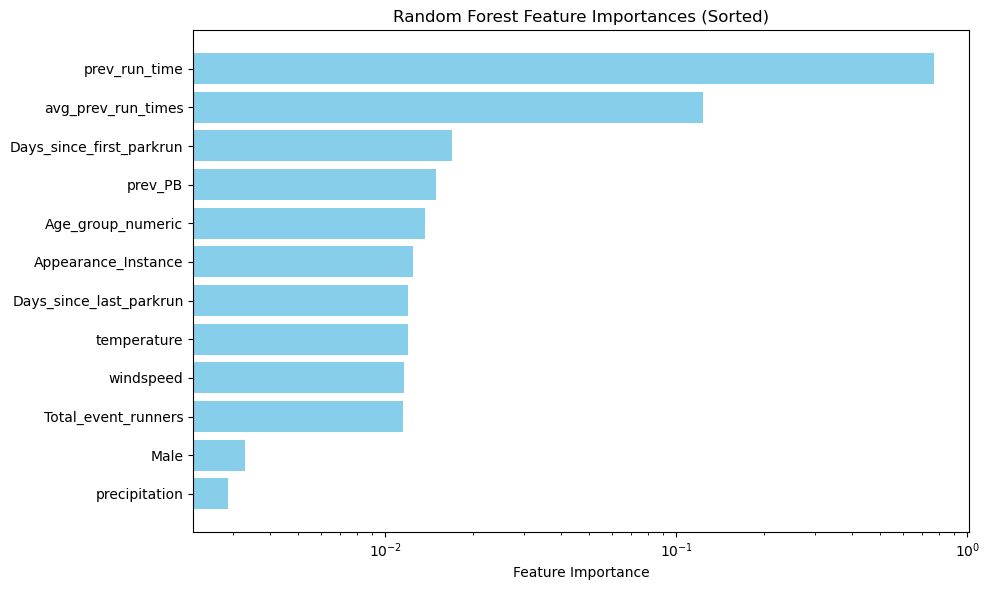

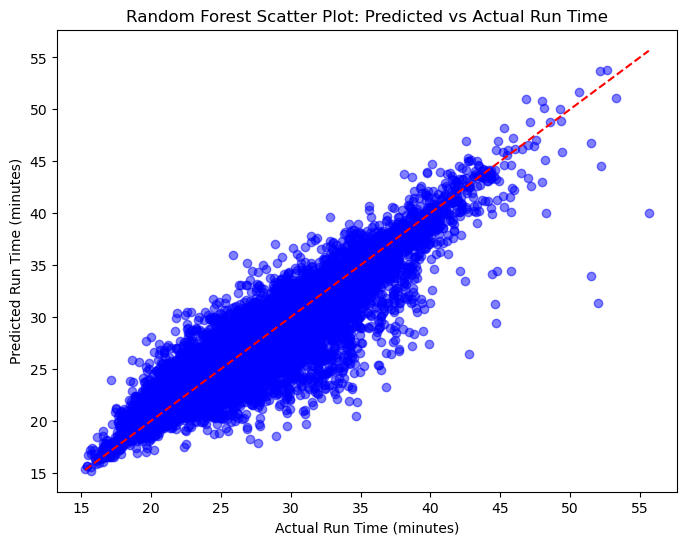

[0.76579092 0.12306921 0.01697649 0.01495556 0.01368335 0.01244857
 0.01193363 0.01191575 0.01158713 0.01146363 0.00328771 0.00288805]


In [92]:
# Call functions to visualize feature importance and predicted vs actual
rf_features = plot_feature_importance(rf, X_train_norm_df.columns, 'Random Forest')
plot_predicted_vs_actual(y_test, y_pred_rf, 'Random Forest')
print(rf_features)

### Linear Regression:

In [96]:
# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_norm_df, y_train)

with open('models/excluding_outliers/linear_regression_model_2.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Predict on test set
y_pred_lr = lr.predict(X_test_norm_df)

# Evaluate the model
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')


Linear Regression - RMSE: 1.742
Linear Regression - R-squared: 0.86


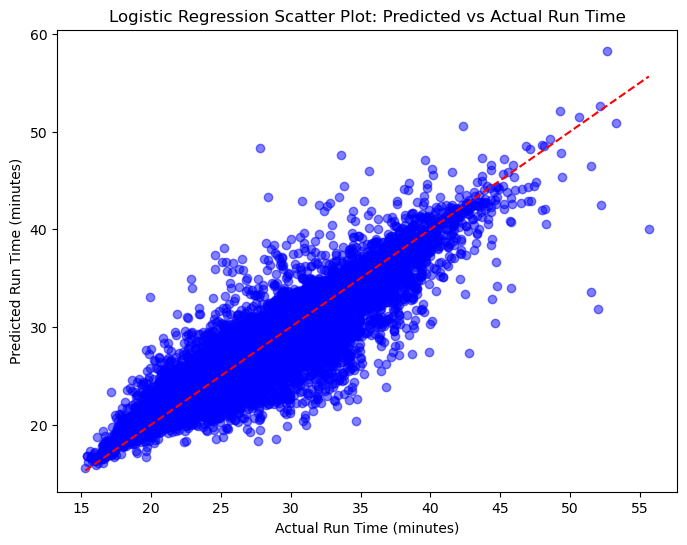

In [98]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_lr, 'Logistic Regression')

### Gradient Boosting Regressor:

In [100]:
# Initialize and train Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb.fit(X_train_norm_df, y_train)

with open('models/excluding_outliers/gradient_boosting_model_2.pkl', 'wb') as f:
    pickle.dump(gb, f)

# Predict on test set
y_pred_gb = gb.predict(X_test_norm_df)

# Evaluate the model
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')


Gradient Boosting - RMSE: 1.621
Gradient Boosting - R-squared: 0.878


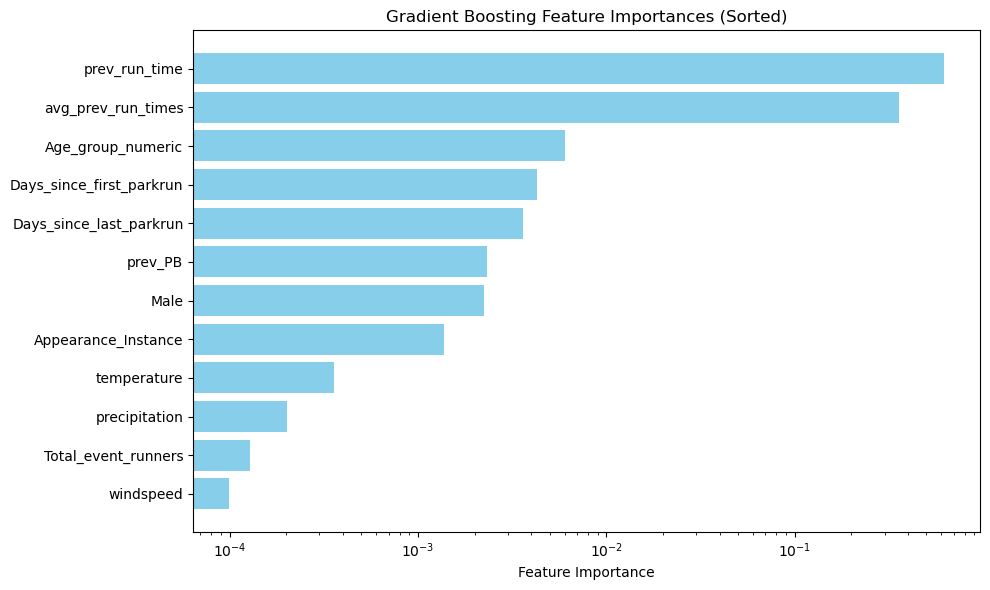

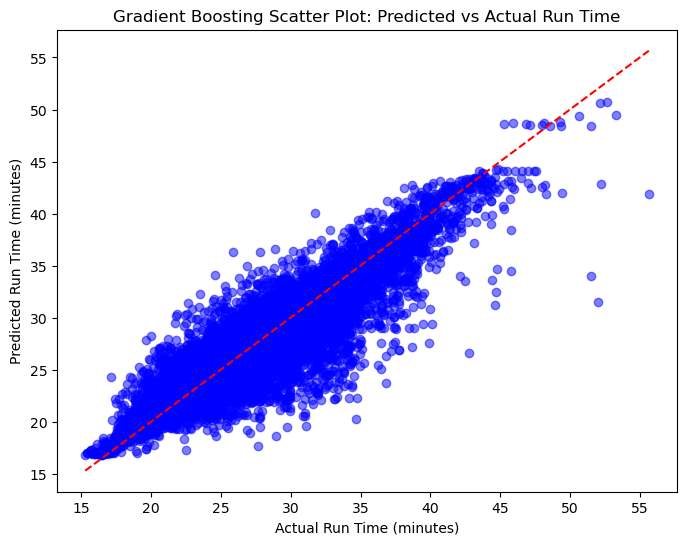

In [101]:
# Visualize results
gb_features = plot_feature_importance(gb, X_train_norm_df.columns, 'Gradient Boosting')
plot_predicted_vs_actual(y_test, y_pred_gb, 'Gradient Boosting')

### XGB Regressor:

In [102]:
# Initialize and train XGBoost model
xg = xgb.XGBRegressor(n_estimators=100, random_state=0)
xg.fit(X_train_norm_df, y_train)

with open('models/excluding_outliers/xgb_model_2.pkl', 'wb') as f:
    pickle.dump(xg, f)

# Predict on test set
y_pred_xg = xg.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')


XGBoost - RMSE: 1.589
XGBoost - R-squared: 0.883


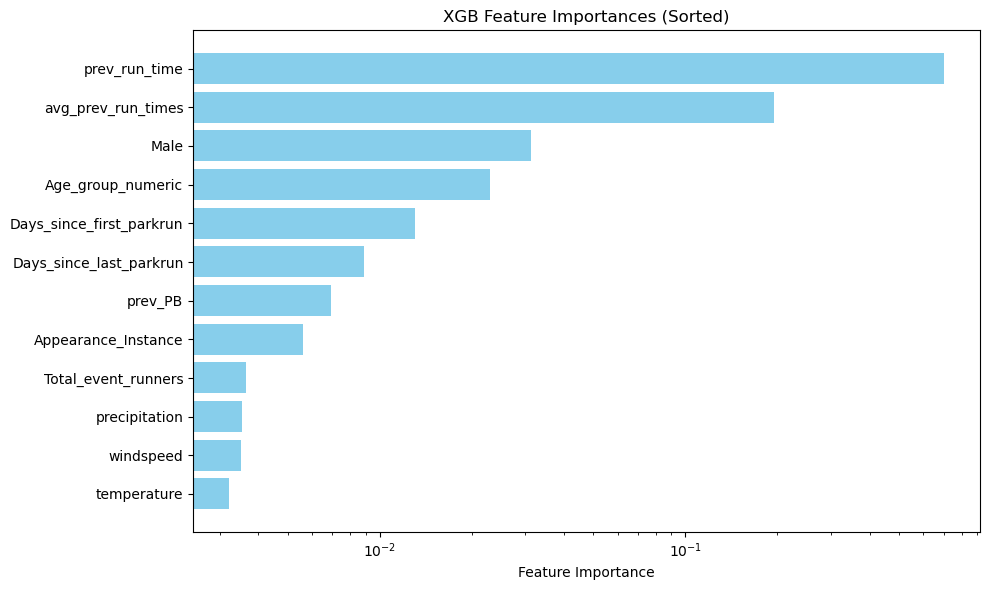

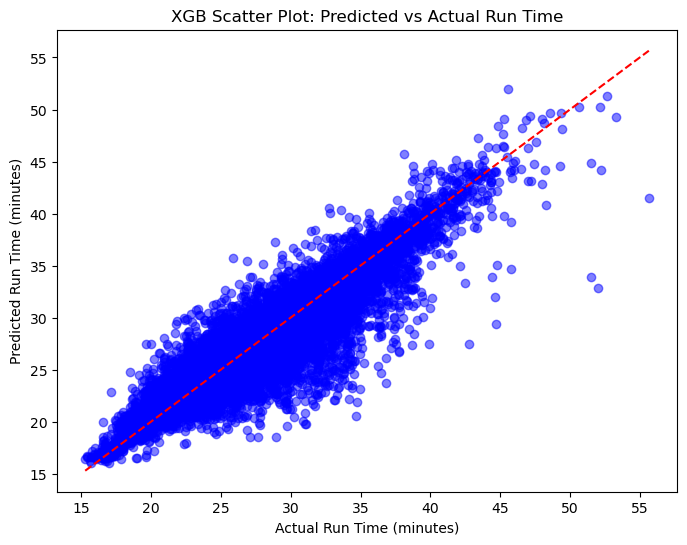

In [103]:
# Visualize results
xg_features = plot_feature_importance(xg, X_train_norm_df.columns, 'XGB')
plot_predicted_vs_actual(y_test, y_pred_xg, 'XGB')

### K-Nearest Neighbours:

In [104]:
# Initialize and train KNN model
knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_knn = knn.predict(X_test_norm_df)

with open('models/excluding_outliers/knn_model_2.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Evaluate the model
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')


KNN - RMSE: 1.889
KNN - R-squared: 0.835


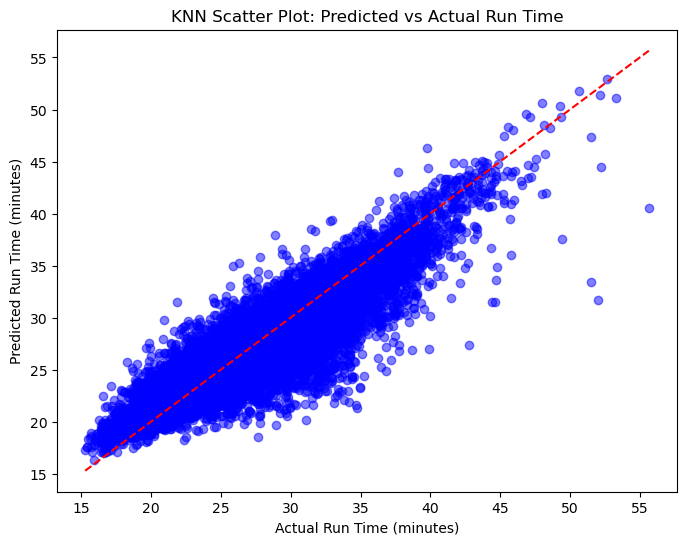

In [105]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_knn, 'KNN')

### Assess model performance:

In [ ]:
print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')
print('')
print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')
print('')
print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')
print('')
print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')
print('')
print(f'Random Forest - RMSE: {rmse.round(3)}')
print(f'Random Forest - R-squared: {r2.round(3)}')

## Optimise models

### Grid Search optimised XGB:

In [116]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the model
xgb = XGBRegressor(random_state=0)

# Define a smaller, more efficient parameter grid
params = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.02, 0.05, 0.1],  
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

# Run the grid search and print the progress manually
grid_search.fit(X_train_norm_df, y_train)

# Now that grid search is complete, we can access cv_results_
total_combinations = len(grid_search.cv_results_['params'])

# Print progress
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Testing model {i + 1} out of {total_combinations} with parameters: {params}")

# Best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Testing model 1 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 100}
Testing model 2 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200}
Testing model 3 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 300}
Testing model 4 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100}
Testing model 5 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 200}
Testing model 6 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 300}
Testing model 7 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 100}
Testing model 8 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 200}
Testing model 9 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 300}
Tes

Test RMSE: 1.572
Test R-squared: 0.886


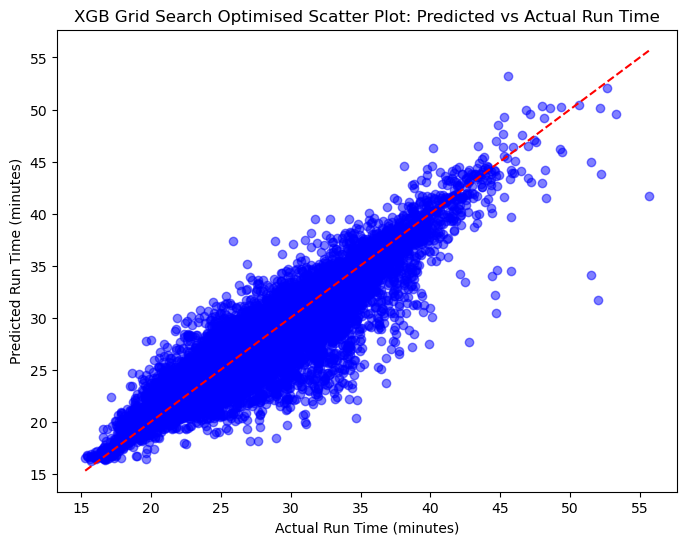

In [118]:
#colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0

# Retrieve the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = XGBRegressor(**best_params, random_state=0)
best_model.fit(X_train_norm_df, y_train)

with open('models/excluding_outliers/optimised/xgb_grid_search_model_2.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Predict on the test set
y_pred_xg_grid = best_model.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg_grid)
r2_xg = r2_score(y_test, y_pred_xg_grid)

print(f"Test RMSE: {rmse_xg:.3f}")
print(f"Test R-squared: {r2_xg:.3f}")

plot_predicted_vs_actual(y_test, y_pred_xg_grid, 'XGB Grid Search Optimised')

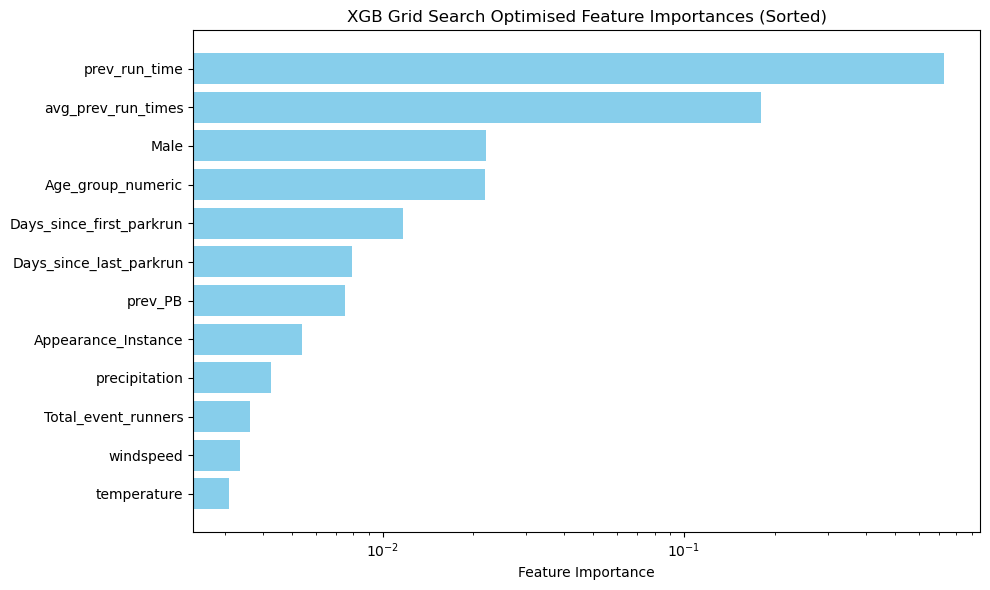

array([0.7291513 , 0.1799443 , 0.022085  , 0.02188111, 0.01171315,
       0.0079122 , 0.00752879, 0.00540449, 0.00426792, 0.00364473,
       0.00337251, 0.00309453], dtype=float32)

In [120]:
xgb_grid_search_features = plot_feature_importance(best_model, X_train_norm_df.columns, 'XGB Grid Search Optimised')
xgb_grid_search_features

## Optuna Bayesian optimisation:

In [143]:
def objective(trial):
    # Define hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Create and evaluate the model
    model = XGBRegressor(**params, random_state=0)
    scores = cross_val_score(model, X_train_norm_df, y_train, 
                             cv=5, scoring=make_scorer(root_mean_squared_error, greater_is_better=False))
    
    return np.mean(scores)

In [145]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # Adjust n_trials as needed

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-12-13 14:51:46,173] A new study created in memory with name: no-name-02aab03d-68d0-4094-9378-ade2150df573
[I 2024-12-13 14:52:10,028] Trial 0 finished with value: -1.7258501391457841 and parameters: {'n_estimators': 141, 'max_depth': 10, 'learning_rate': 0.013678161398851899, 'subsample': 0.844638550265999, 'colsample_bytree': 0.9611398450879889, 'gamma': 1.4468647708120952, 'reg_alpha': 0.7316993415696227, 'reg_lambda': 4.965199948301714}. Best is trial 0 with value: -1.7258501391457841.
[I 2024-12-13 14:52:16,852] Trial 1 finished with value: -2.117548907122944 and parameters: {'n_estimators': 96, 'max_depth': 6, 'learning_rate': 0.013015879636701755, 'subsample': 0.8608099409043682, 'colsample_bytree': 0.6622130688420055, 'gamma': 3.3304188535581525, 'reg_alpha': 9.046611625149957, 'reg_lambda': 8.657218361572665}. Best is trial 0 with value: -1.7258501391457841.
[I 2024-12-13 14:52:26,986] Trial 2 finished with value: -1.600994455449261 and parameters: {'n_estimators': 209,

Best Parameters: {'n_estimators': 298, 'max_depth': 8, 'learning_rate': 0.048316743485541706, 'subsample': 0.7648251584711095, 'colsample_bytree': 0.7235653210958961, 'gamma': 4.015656418391725, 'reg_alpha': 1.8541763047399846, 'reg_lambda': 2.7037454865256327}
Best RMSE: -1.5706228333758196


Training RMSE: 1.377
Training R-squared: 0.913

Test RMSE: 1.564
Test R-squared: 0.887


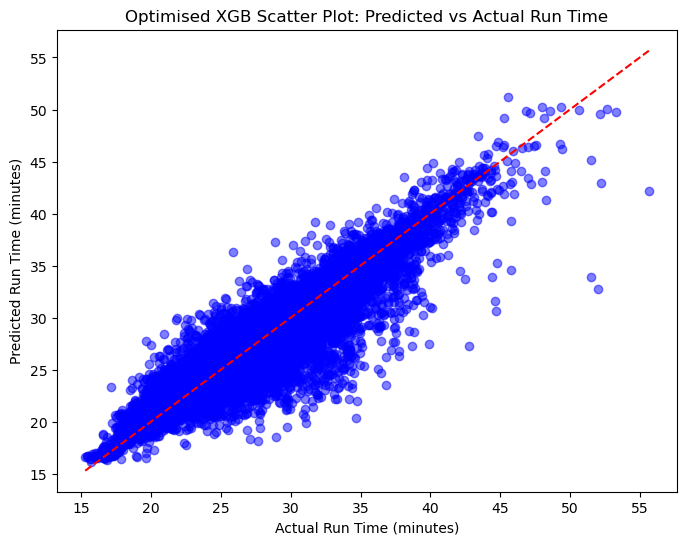

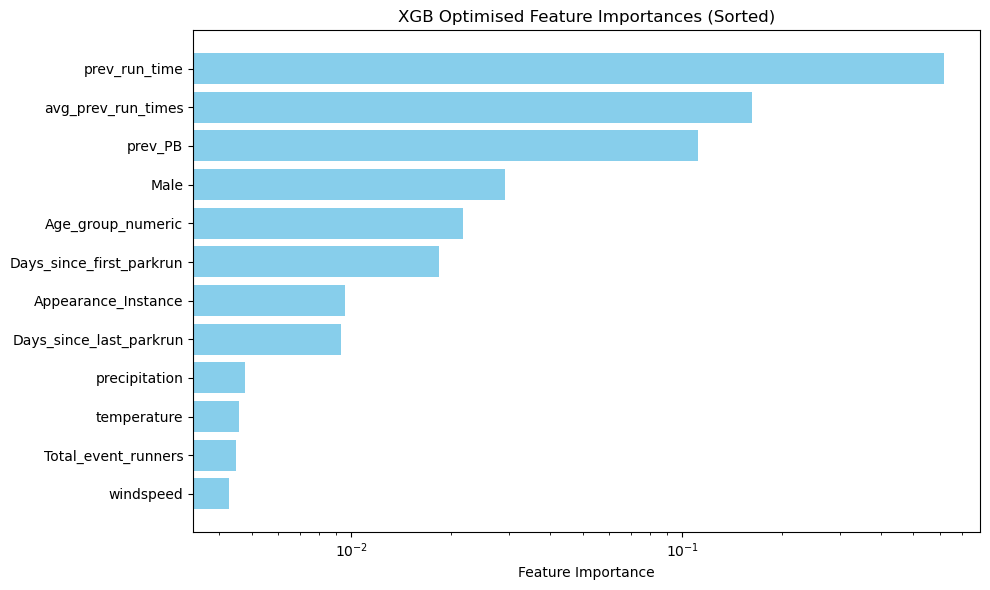

In [146]:
# Train final model with best parameters
best_params = study.best_params
best_xgb_model = XGBRegressor(**best_params, random_state=0)
best_xgb_model.fit(X_train_norm_df, y_train)

with open('models/excluding_outliers/optimised/xgb_opt_model_2.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Evaluate on test data
y_pred_opt_test = best_xgb_model.predict(X_test_norm_df)
rmse_opt_test = root_mean_squared_error(y_test, y_pred_opt_test)
r2_opt_test = r2_score(y_test, y_pred_opt_test)

# Evaluate on training data
y_pred_opt_train = best_xgb_model.predict(X_train_norm_df)
rmse_opt_train = root_mean_squared_error(y_train, y_pred_opt_train)
r2_opt_train = r2_score(y_train, y_pred_opt_train)

# Print results
print(f"Training RMSE: {rmse_opt_train:.3f}")
print(f"Training R-squared: {r2_opt_train:.3f}")
print("")
print(f"Test RMSE: {rmse_opt_test:.3f}")
print(f"Test R-squared: {r2_opt_test:.3f}")

plot_predicted_vs_actual(y_test, y_pred_opt_test, 'Optimised XGB')
best_xgb_features = plot_feature_importance(best_xgb_model, X_train_norm_df.columns, 'XGB Optimised')

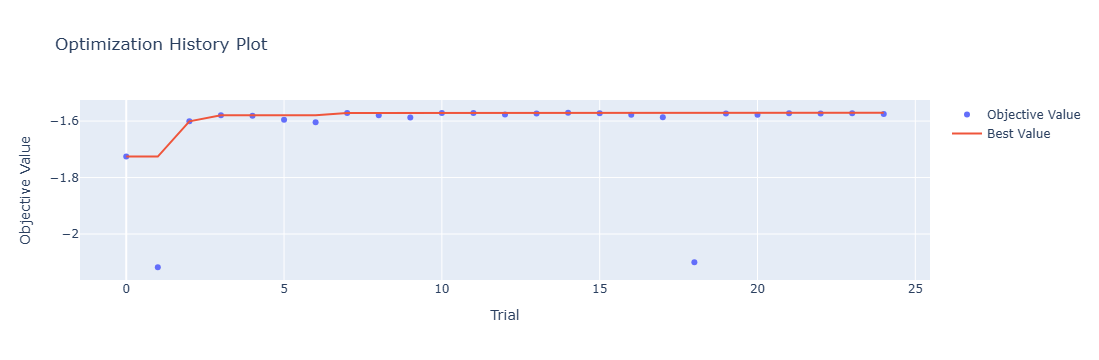

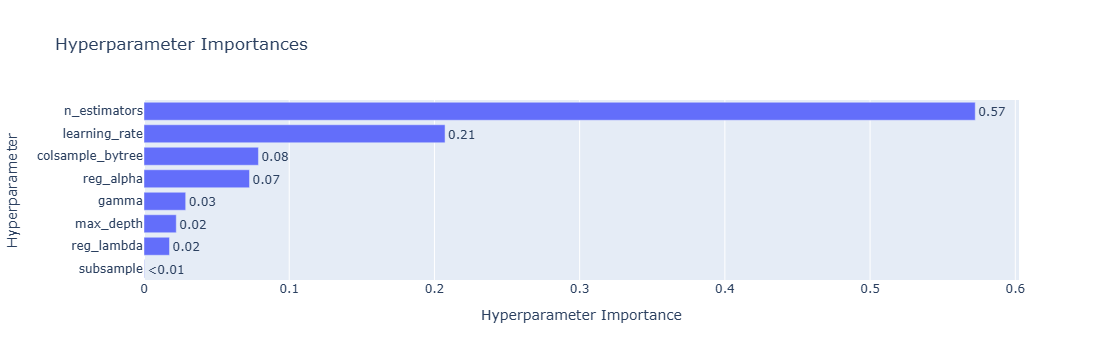

In [147]:
plot_optimization_history(study).show()
plot_param_importances(study).show()

### Recursive Feature Elimination:

In [148]:
# Use RFE for feature selection
rfe = RFE(estimator=best_xgb_model, n_features_to_select=5)

# Fit the RFE model and track progress manually
num_features = X_train_norm_df.shape[1]  # Total number of features
print(f"Starting RFE with {num_features} features. Progress will be displayed...")

# Fit the RFE model and track iterations
for i in range(num_features, 0, -1):  # RFE reduces features, start from the full set
    rfe.n_features_to_select = i  # Reduce the number of features in each iteration
    rfe.fit(X_train_norm_df, y_train)
    
    # After each iteration, print the progress
    print(f"RFE iteration {num_features - i + 1}/{num_features}: {i} features remaining.")


# Get selected features and their rankings
selected_features = rfe.support_  # Boolean mask of selected features
feature_ranking = rfe.ranking_    # Feature ranking (1 means selected)

# Print results
print("Selected Features (True = Selected):", selected_features)
print("Feature Ranking:", feature_ranking)

Starting RFE with 12 features. Progress will be displayed...
RFE iteration 1/12: 12 features remaining.
RFE iteration 2/12: 11 features remaining.
RFE iteration 3/12: 10 features remaining.
RFE iteration 4/12: 9 features remaining.
RFE iteration 5/12: 8 features remaining.
RFE iteration 6/12: 7 features remaining.
RFE iteration 7/12: 6 features remaining.
RFE iteration 8/12: 5 features remaining.
RFE iteration 9/12: 4 features remaining.
RFE iteration 10/12: 3 features remaining.
RFE iteration 11/12: 2 features remaining.
RFE iteration 12/12: 1 features remaining.
Selected Features (True = Selected): [False False False False False False False False  True False False False]
Feature Ranking: [ 9 12 10  7  8 11  2  3  1  5  6  4]


In [149]:
ranked_columns = [(col, rank) for col, rank in zip(X_train_norm_df.columns, feature_ranking)]

ranked_columns = sorted(ranked_columns, key=lambda x: x[1])
ranked_columns

[('avg_prev_run_times', 1),
 ('prev_run_time', 2),
 ('prev_PB', 3),
 ('Male', 4),
 ('Age_group_numeric', 5),
 ('Days_since_first_parkrun', 6),
 ('Appearance_Instance', 7),
 ('Days_since_last_parkrun', 8),
 ('temperature', 9),
 ('precipitation', 10),
 ('Total_event_runners', 11),
 ('windspeed', 12)]

### Optimise by top n Features

In [150]:
# Function to optimise model based on top n features only

def optimize_and_train_model(sorted_features, X_train_norm_df, X_test_norm_df, y_train, y_test, model_save_path, top_n=6, n_trials=50):
    """
    Function to optimize an XGBoost model using Optuna, train it with the best parameters, 
    and evaluate it on training and test sets.

    Parameters:
    sorted_features: List of tuples containing feature names and their scores, sorted by importance.
    X_train_norm_df: DataFrame containing normalized training features.
    X_test_norm_df: DataFrame containing normalized test features.
    y_train: Training target variable.
    y_test: Test target variable.
    top_n: Number of top features to use for optimization. Default is 6.
    n_trials: Number of trials for Optuna optimization. Default is 50.
    model_save_path: Path to save the trained model.

    Returns:
    study: Optuna study object containing optimization results.
    best_model: Trained XGBoost model with the best parameters.
    """
    # Select top N features
    top_n_cols = [feature[0] for feature in sorted_features[:top_n]]
    filt_X_train_norm_df = X_train_norm_df[top_n_cols]
    filt_X_test_norm_df = X_test_norm_df[top_n_cols]

    # Define the objective function for Optuna
    def objective(trial):
        # Define hyperparameter space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        }

        # Create and evaluate the model
        model = XGBRegressor(**params, random_state=0)
        scores = cross_val_score(
            model, filt_X_train_norm_df, y_train, 
            cv=5, scoring=make_scorer(root_mean_squared_error, greater_is_better=False)
        )
        return np.mean(scores)

    # Run the Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Train the final model with the best parameters
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, random_state=0)
    best_model.fit(filt_X_train_norm_df, y_train)

    # Save the trained model
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)

    # Evaluate on test data
    y_pred_test = best_model.predict(filt_X_test_norm_df)
    rmse_test = np.sqrt(np.mean((y_test - y_pred_test) ** 2))  # Root Mean Squared Error
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on training data
    y_pred_train = best_model.predict(filt_X_train_norm_df)
    rmse_train = np.sqrt(np.mean((y_train - y_pred_train) ** 2))  # Root Mean Squared Error
    r2_train = r2_score(y_train, y_pred_train)

    # Print results
    print(f"Top {top_n} Features Used: {top_n_cols}")
    print("Best Parameters:", best_params)
    print("")
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse_test:.3f}")
    print(f"Test R-squared: {r2_test:.3f}")

    return study, best_model

In [151]:
study5, best_model5 = optimize_and_train_model(
    top_n=5,
    model_save_path="models/excluding_outliers/optimised/xgb_opt_5_features_model_2.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)

[I 2024-12-13 15:04:54,563] A new study created in memory with name: no-name-5a5a82f6-95bf-4414-bca8-73711fc02165
[I 2024-12-13 15:04:59,769] Trial 0 finished with value: -1.6387677406924563 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.29794130692372217, 'subsample': 0.9913948339684542, 'colsample_bytree': 0.9666325847963623, 'gamma': 1.0466421906897168, 'reg_alpha': 1.4555289579424358, 'reg_lambda': 3.737503879030534}. Best is trial 0 with value: -1.6387677406924563.
[I 2024-12-13 15:05:11,125] Trial 1 finished with value: -1.6330595332389002 and parameters: {'n_estimators': 286, 'max_depth': 7, 'learning_rate': 0.11136556035654294, 'subsample': 0.6422913329531319, 'colsample_bytree': 0.7860203030603026, 'gamma': 4.902860377653532, 'reg_alpha': 2.844400140315817, 'reg_lambda': 9.412766543451212}. Best is trial 1 with value: -1.6330595332389002.
[I 2024-12-13 15:05:15,026] Trial 2 finished with value: -1.6463819023343376 and parameters: {'n_estimators': 81, 

Top 5 Features Used: ['avg_prev_run_times', 'prev_run_time', 'prev_PB', 'Male', 'Age_group_numeric']
Best Parameters: {'n_estimators': 226, 'max_depth': 10, 'learning_rate': 0.03975731015122536, 'subsample': 0.6004535474903886, 'colsample_bytree': 0.866074645212611, 'gamma': 3.646823235310462, 'reg_alpha': 6.206391911330198, 'reg_lambda': 0.18593275215764166}

Training RMSE: 1.505
Training R-squared: 0.896

Test RMSE: 1.622
Test R-squared: 0.878


In [152]:
study6, best_model6 = optimize_and_train_model(
    top_n=6,
    model_save_path="models/excluding_outliers/optimised/xgb_opt_6_features_model_2.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)


[I 2024-12-13 15:08:18,178] A new study created in memory with name: no-name-1f8f4edc-b2a6-4c81-9bc9-4b44cc7eeb3e
[I 2024-12-13 15:08:33,166] Trial 0 finished with value: -1.6113230792182562 and parameters: {'n_estimators': 283, 'max_depth': 7, 'learning_rate': 0.15072982607110755, 'subsample': 0.6990776464391202, 'colsample_bytree': 0.9038743911660264, 'gamma': 1.9599903528181821, 'reg_alpha': 4.442032482716237, 'reg_lambda': 5.551237422405988}. Best is trial 0 with value: -1.6113230792182562.
[I 2024-12-13 15:08:35,979] Trial 1 finished with value: -1.6485163083858505 and parameters: {'n_estimators': 69, 'max_depth': 3, 'learning_rate': 0.15337695359124445, 'subsample': 0.6123633382394895, 'colsample_bytree': 0.757780402592969, 'gamma': 0.5976747245717023, 'reg_alpha': 3.227848527196111, 'reg_lambda': 2.905781068237485}. Best is trial 0 with value: -1.6113230792182562.
[I 2024-12-13 15:08:45,326] Trial 2 finished with value: -1.611302215390714 and parameters: {'n_estimators': 254, 'm

Top 6 Features Used: ['avg_prev_run_times', 'prev_run_time', 'prev_PB', 'Male', 'Age_group_numeric', 'Days_since_first_parkrun']
Best Parameters: {'n_estimators': 156, 'max_depth': 10, 'learning_rate': 0.07381301331655835, 'subsample': 0.77862147328421, 'colsample_bytree': 0.768361867404424, 'gamma': 0.0685360656982581, 'reg_alpha': 8.058172336081437, 'reg_lambda': 6.838046132455716}

Training RMSE: 1.448
Training R-squared: 0.904

Test RMSE: 1.593
Test R-squared: 0.882


In [153]:
study7, best_model7 = optimize_and_train_model(
    top_n=7,
    model_save_path="models/excluding_outliers/optimised/xgb_opt_7_features_model_2.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)


[I 2024-12-13 15:11:56,926] A new study created in memory with name: no-name-3e2850f7-f0bd-4d3b-ab92-d58b02aa544c
[I 2024-12-13 15:12:09,511] Trial 0 finished with value: -1.6027083175670043 and parameters: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.12022776176040612, 'subsample': 0.9269134759391657, 'colsample_bytree': 0.7358233764428573, 'gamma': 0.43134919177390374, 'reg_alpha': 0.8528799244193463, 'reg_lambda': 9.133438655901113}. Best is trial 0 with value: -1.6027083175670043.
[I 2024-12-13 15:12:29,462] Trial 1 finished with value: -1.6555427017620665 and parameters: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.01129302168035757, 'subsample': 0.6441635782285202, 'colsample_bytree': 0.6032136057675168, 'gamma': 1.2262728146257684, 'reg_alpha': 8.316713752165338, 'reg_lambda': 0.7094591326897137}. Best is trial 0 with value: -1.6027083175670043.
[I 2024-12-13 15:12:40,129] Trial 2 finished with value: -1.6148156145348238 and parameters: {'n_estimators': 2

Top 7 Features Used: ['avg_prev_run_times', 'prev_run_time', 'prev_PB', 'Male', 'Age_group_numeric', 'Days_since_first_parkrun', 'Appearance_Instance']
Best Parameters: {'n_estimators': 248, 'max_depth': 10, 'learning_rate': 0.025190854921459446, 'subsample': 0.6092459664319706, 'colsample_bytree': 0.6595060151077332, 'gamma': 1.545097054194041, 'reg_alpha': 2.398731840502107, 'reg_lambda': 6.620856147462028}

Training RMSE: 1.470
Training R-squared: 0.901

Test RMSE: 1.589
Test R-squared: 0.883


In [154]:

study8, best_model8 = optimize_and_train_model(
    top_n=8,
    model_save_path="models/excluding_outliers/optimised/xgb_opt_8_features_model_2.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)

[I 2024-12-13 15:16:24,155] A new study created in memory with name: no-name-1d8d3a11-b2a8-443f-9153-669e93c5f6b7
[I 2024-12-13 15:16:31,062] Trial 0 finished with value: -1.5807728490374284 and parameters: {'n_estimators': 143, 'max_depth': 9, 'learning_rate': 0.14618569220816813, 'subsample': 0.9197674968239914, 'colsample_bytree': 0.7828633302449873, 'gamma': 4.944279667433301, 'reg_alpha': 8.05319165864067, 'reg_lambda': 3.428341917123876}. Best is trial 0 with value: -1.5807728490374284.
[I 2024-12-13 15:16:38,408] Trial 1 finished with value: -1.580383430679537 and parameters: {'n_estimators': 117, 'max_depth': 7, 'learning_rate': 0.11255427553676418, 'subsample': 0.732077089079947, 'colsample_bytree': 0.7650354427183074, 'gamma': 0.880660100023854, 'reg_alpha': 7.6368481868221565, 'reg_lambda': 9.114859912206308}. Best is trial 1 with value: -1.580383430679537.
[I 2024-12-13 15:16:49,398] Trial 2 finished with value: -1.6035072940578097 and parameters: {'n_estimators': 201, 'max

Top 8 Features Used: ['avg_prev_run_times', 'prev_run_time', 'prev_PB', 'Male', 'Age_group_numeric', 'Days_since_first_parkrun', 'Appearance_Instance', 'Days_since_last_parkrun']
Best Parameters: {'n_estimators': 171, 'max_depth': 10, 'learning_rate': 0.041051748638897455, 'subsample': 0.7921660007577462, 'colsample_bytree': 0.8636111130285965, 'gamma': 3.973405985612031, 'reg_alpha': 2.4789156747205476, 'reg_lambda': 1.3932528716740677}

Training RMSE: 1.346
Training R-squared: 0.917

Test RMSE: 1.570
Test R-squared: 0.886


### Evaluate models with restricted features

In [ ]:
def evaluate_model(model, feature_count, title, ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test):
    # Select top N features based on sorted feature ranking
    top_n_cols = [feature[0] for feature in ranked_columns[:feature_count]]
    
    # Ensure columns are available in both training and test data
    X_train_selected = X_train_norm_df[top_n_cols]
    X_test_selected = X_test_norm_df[top_n_cols]  # Use the same columns for the test set
    
    # Predict on test data
    y_pred = model.predict(X_test_selected)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Predict on training data with selected features
    y_pred_train = model.predict(X_train_selected)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Print results
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R-squared: {r2:.3f}")
    
    # Plot predicted vs actual for test set
    plot_predicted_vs_actual(y_test, y_pred, title)
    
    return best_xgb_features

Training RMSE: 1.505
Training R-squared: 0.896

Test RMSE: 1.622
Test R-squared: 0.878


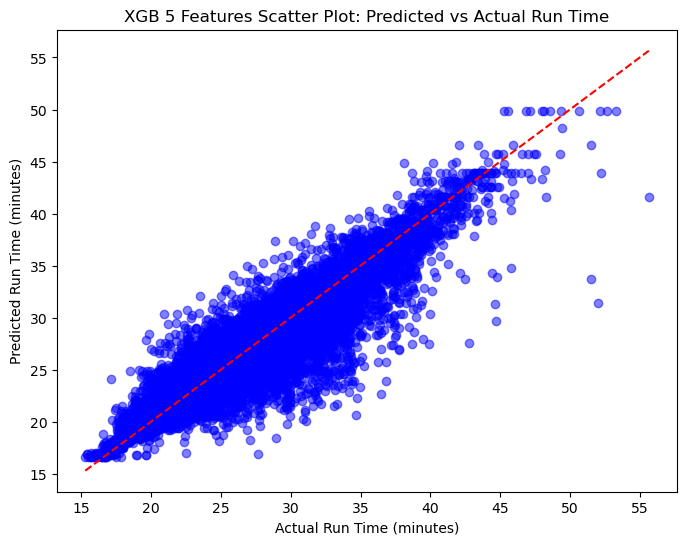

array([0.6192576 , 0.16277064, 0.11145555, 0.02915771, 0.02183986,
       0.01844668, 0.00960582, 0.00933153, 0.00478288, 0.00458986,
       0.00448798, 0.00427389], dtype=float32)

In [166]:
evaluate_model(best_model5, 5, 'XGB 5 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 1.448
Training R-squared: 0.904

Test RMSE: 1.593
Test R-squared: 0.882


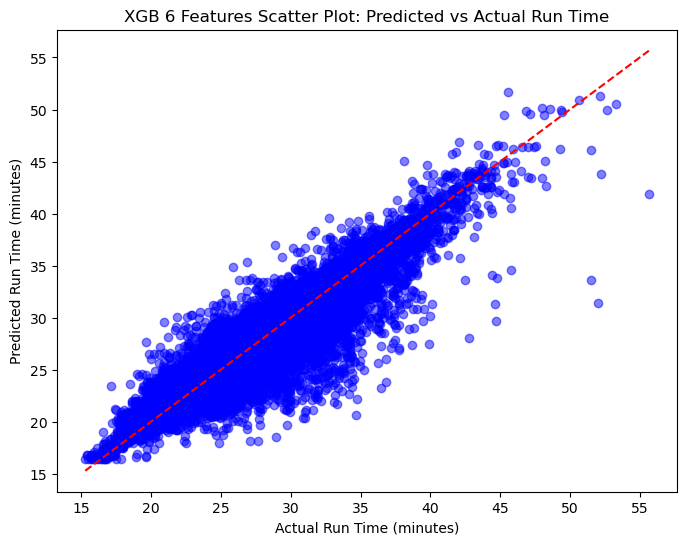

array([0.6192576 , 0.16277064, 0.11145555, 0.02915771, 0.02183986,
       0.01844668, 0.00960582, 0.00933153, 0.00478288, 0.00458986,
       0.00448798, 0.00427389], dtype=float32)

In [167]:
evaluate_model(best_model6, 6, 'XGB 6 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 1.470
Training R-squared: 0.901

Test RMSE: 1.589
Test R-squared: 0.883


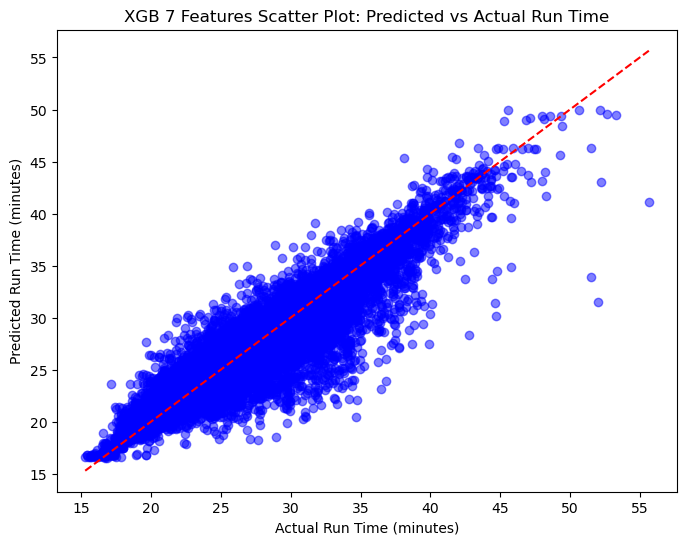

array([0.6192576 , 0.16277064, 0.11145555, 0.02915771, 0.02183986,
       0.01844668, 0.00960582, 0.00933153, 0.00478288, 0.00458986,
       0.00448798, 0.00427389], dtype=float32)

In [168]:
evaluate_model(best_model7, 7, 'XGB 7 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 1.346
Training R-squared: 0.917

Test RMSE: 1.570
Test R-squared: 0.886


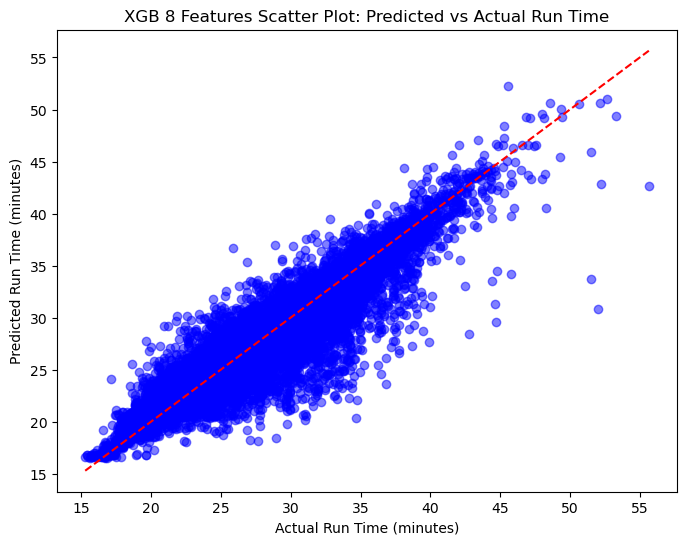

array([0.6192576 , 0.16277064, 0.11145555, 0.02915771, 0.02183986,
       0.01844668, 0.00960582, 0.00933153, 0.00478288, 0.00458986,
       0.00448798, 0.00427389], dtype=float32)

In [170]:
evaluate_model(best_model8, 8, 'XGB 8 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)